## 1. Import relevant libraries

In [25]:
import requests
import json
import pandas as pd
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import gdal
import rasterio
from rasterio.plot import show
from rasterio import plot
from rasterio.mask import mask
import requests
import json
import geopandas as gpd
import plotly.graph_objects as go

from mpl_toolkits.mplot3d.axes3d import *

## 2. Exploring the raster Images

- In this code segment, I explore the Digtal Surface Model(dsm) and the Digtal Terrain Model(dtm).
- Useful information on the raster images is generated, such as :

    - Image bounds, 
    - Coordinate refrence system (crs)
    - Displaying image array
    - Images of the untransformed and transformed rasters are displayed

### Exploring info on Digtal Surface Model(DSM) 

In [2]:
path1 = 'C:/Users/makye/Downloads/geotiff/DSM/ExtractedDSM/DHMVIIDSMRAS1m_k01/GeoTIFF/DHMVIIDSMRAS1m_k01.tif'
dsm  = rasterio.open(path1)
array_dsm = dsm.read(1) #Raster array
array_dsm.size
dsm.crs #Coordinate refrence system of dsm
dsm.count #number of bands
print(dsm.width, dsm.height) #Height vs Widith
dsm.bounds #checks bounds of ds

17000 9000


BoundingBox(left=145000.0, bottom=238000.0, right=162000.0, top=247000.0)

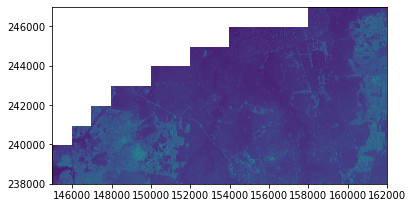

<AxesSubplot:>

In [3]:
#Untransformed DSM

show(dsm)

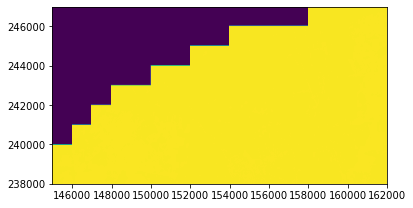

<AxesSubplot:>

In [4]:
#transformed DSM
show(dsm.read(), transform=dsm.transform)



### Exploring info on Digtal Terrain Model(DTM) 

In [5]:
path2 = 'C:/Users/makye/Downloads/geotiff/DTM/DHMVIIDTMRAS1m_k01/GeoTIFF/DHMVIIDTMRAS1m_k01.tif'
dtm  = rasterio.open(path2)
array_dtm = dtm.read(1) #Raster array
array_dtm.size
dtm.crs #Coordinate refrence system
dtm.count #number of bands
print(dtm.width, dtm.height)#Height vs Widith
dtm.bounds #checks bounds of tiff image


17000 9000


BoundingBox(left=145000.0, bottom=238000.0, right=162000.0, top=247000.0)

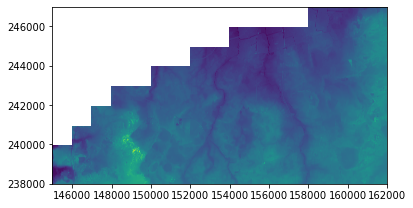

<AxesSubplot:>

In [6]:
#Untransformed DTM

show(dtm)

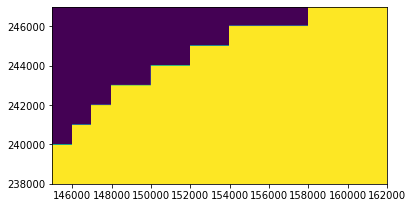

<AxesSubplot:>

In [7]:
#transformed DTM

show(dtm.read(), transform=dtm.transform)


## 3. Obtaining the Canopy Hieght Model (CHM)

- Under this code segment, the CHM is generated by subtracting DTM array from the DSM array
- A 2D plot of the CHM is generated for visual exploration
- The CHM raster is then exported to a target local directory

### Subtracting DTM from DSM

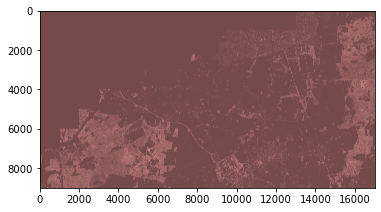

In [8]:
#from above, DSM and DTM are of same size i.e 153000000 & bounds

#Array for the canopy height model(CHM)
array_chm = array_dsm - array_dtm

#Plotting canopy height model
plt.imshow(array_chm, cmap='pink')

### Writing and exporting CHM

In [9]:
#Adapting output chm to dimesions of DSM
dsm_transform = dsm.transform
dsm_crs = dsm.crs

new_dataset = rasterio.open(
       'C:/Users/makye/Downloads/geotiff/CHM/chm.tif',
       'w',
       driver='GTiff',
       height=array_chm.shape[0],
       width=array_chm.shape[1],
       count=1,
       dtype=array_chm.dtype,
       crs=dsm_crs,
       transform=dsm_transform,
)  

new_dataset.write(array_chm, 1)
new_dataset.close()

In [37]:
#openign & potting  CHM
path3 = 'C:/Users/makye/Downloads/geotiff/CHM/chm.tif'
chm  = rasterio.open(path3)


## 4. Generating polygon of input home address
- Under this code segment:
    - From the API: basisregisters.vlaanderen.be
    - I use the requests & Json libraries to obtain polygon coordinates of input home address 
    - The generated polygon is plotted for visual exploration
    

0    POLYGON ((160102.710 241040.277, 160112.862 24...
Name: geometry, dtype: geometry


<AxesSubplot:>

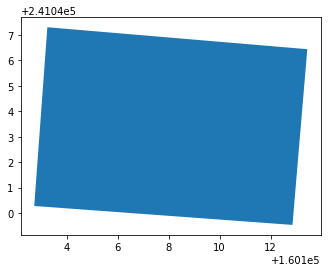

In [14]:
#Creating an instance of the home address API
url1 = 'https://api.basisregisters.vlaanderen.be/v1/adresmatch'

#Requesting address details from API
address = requests.get(url1, params={'postcode':2910, 
                              'straatnaam':'Raaiberg', 'huisnummer':47})

data = json.loads(address.text)
block_url = data['adresMatches'][0]['adresseerbareObjecten'][0]['detail']
request_block = requests.get(block_url)
data1 = json.loads(request_block.text)
building_url = data1['gebouw']['detail']
request_building = requests.get(building_url)
data2 = json.loads(request_building.text)
coordinates = data2['geometriePolygoon']['polygon']['coordinates'][0]
df = pd.DataFrame(coordinates)
df.columns = ["Latitude", "Longitude"]

#Extracting ploygon
polygon_geom = Polygon(zip(df.Latitude, df.Longitude))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:31370', geometry=[polygon_geom])       

#Print polygon coordinates
print(polygon.geometry)

#Plot polygon
polygon.plot(alpha = 1)

## 5. Musking and clipping chm raster using polygon of home address
- In this code segment, I generate a clipped raster of the chm
- and store it in a target directory

In [21]:
#Check projection of raster and Shapefile(polygon) (must have same Coordinate Refrence System)
chm.crs
polygon.crs

<Projected CRS: EPSG:31370>
Name: Belge 1972 / Belgian Lambert 72
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Belgium - onshore
- bounds: (2.5, 49.5, 6.4, 51.51)
Coordinate Operation:
- name: Belgian Lambert 72
- method: Lambert Conic Conformal (2SP)
Datum: Reseau National Belge 1972
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

### Masking CHM with generated polygon

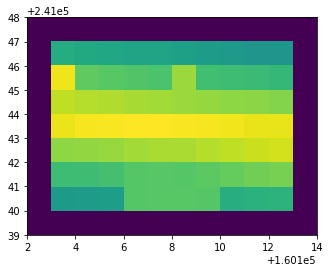

<AxesSubplot:>

In [22]:
#Superimposing, Masking and Clipping CHM raster using house polygon(shapefile) 

masked, mask_transform = mask(dataset=chm,shapes=polygon.geometry,crop=True)

#generate 2D plot of clipped chm ratser
show(masked, transform=mask_transform) 



In [26]:
#profile of CHM (summary information on chm raster)
profile = chm.meta
profile

# update dimensions of the clipped ratser relative to dimensions of orignal chm raster
WIDTH = masked.shape[2] 
HEIGHT = masked.shape[1]
profile.update(driver='GTiff', transform=mask_transform, height = HEIGHT, width = WIDTH)

# check on the updated profile
print(profile) 

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 12, 'height': 9, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 160102.0,
       0.0, -1.0, 241048.0)}


### Writing/saving CHM mask

In [27]:
#writing & saving clipped raster of CHM
with rasterio.open('C:/Users/makye/Downloads/geotiff/CHM/clip.tif', 'w', **profile) as dst:
    dst.write(masked)

## 6. Generating 3D plot of the input home address
- In this code segment, 3D plots of home adress are generated
- First I use the matplotlib library (several formarts of plots are displayed)
- Then I use the Plotly library 

### 3D plot in matplotlib

In [28]:
#Import, examine and geo-transform clipped raster 

path5 = 'C:/Users/makye/Downloads/geotiff/CHM/clip.tif'

clipped = gdal.Open(path5)
array = clipped.ReadAsArray()
gt = clipped.GetGeoTransform()
print(gt)

(160102.0, 1.0, 0.0, 241048.0, 0.0, -1.0)


In [29]:
# transformation of coordinates
xres = gt[1]
yres = gt[5]
X = np.arange(gt[0], gt[0] + array.shape[1]*xres, xres)
Y = np.arange(gt[3], gt[3] + array.shape[0]*yres, yres)
 
# generate a  mesh grid 
X, Y = np.meshgrid(X, Y)



### Line plot of  home address

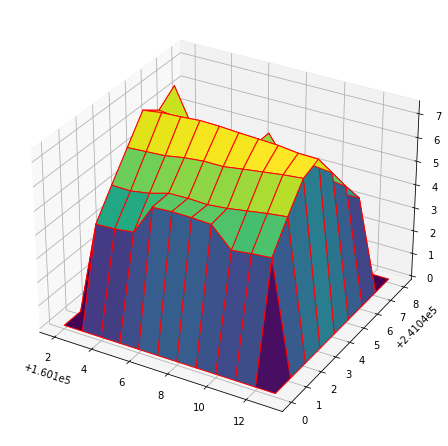

In [30]:
# plot the raster
fig = plt.figure(1, figsize = (9,6))
ax = Axes3D(fig)
ax.plot_surface(X,Y,array,rstride=1, cstride=1,
                cmap='viridis', edgecolor='red'); 


### Contour plot of home address

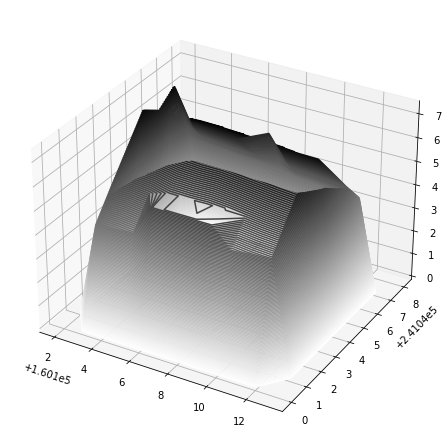

In [34]:

fig = plt.figure(1, figsize = (9,6))
ax = Axes3D(fig)
ax.contour3D(X,Y,array, 150,cmap='binary');  


### Scatter plot of home address

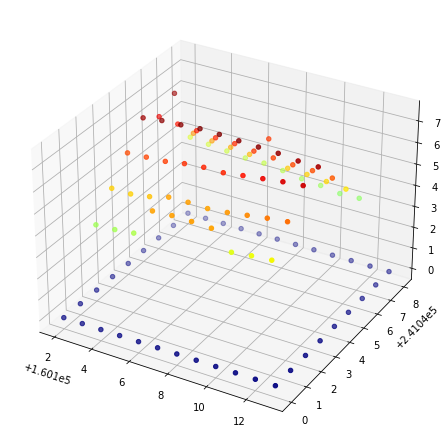

In [35]:
#Scatter plot of home address
fig = plt.figure(1, figsize = (9,6))
ax = Axes3D(fig)
ax.scatter3D(X,Y,array,c=array,cmap=plt.cm.jet, linewidth=1);  


### 3D of home address in Plotly

In [36]:
#Using plotly

array = clipped.ReadAsArray()

fig = go.Figure(data=[go.Surface(z=array)])
fig.update_layout(title='Raaiberg 47-2910-Essen', autosize=False,
                  width=500, height=500,
                  scene = dict(
                    xaxis_title='Distance (m)',
                    yaxis_title='Distance (m)',
                    zaxis_title='Height'),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_scenes(yaxis_autorange="reversed")
fig.show()

